This notebook will train an XGBoost regression model to predict dam fullness
you may not need to run this if you already have the model from the repo

In [31]:
from datetime import datetime
import pickle
import json
import glob
import os

from sklearn.metrics import mean_absolute_error, mean_tweedie_deviance
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
import xgboost
import seaborn as sns; sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np

In [32]:
# path to training and validation data
training_data_path = os.path.join(os.getcwd(),'data/dam forecast train.csv')

val_data_path = os.path.join(os.getcwd(),'data/dam forecast val.csv')

In [33]:
# set location to save model
model_folder = os.getcwd()
model_name = 'dam_forecast_11-10-22.pkl'
model_path = os.path.join(model_folder,'data',model_name)
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'

In [34]:
# we limit the max dam size as large dams are note well represented in our dataset 
max_value = 20000

In [35]:
# load up training data, do some cleaning/sorting
training_data = pd.read_csv(training_data_path)
training_data = training_data.reindex(sorted(training_data.columns), axis=1)
training_data = (training_data[training_data['dam_area'] < max_value])
training_data.replace([np.inf, -np.inf], 0, inplace=True)
training_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20191216,2019.923077,12,2019,2,no water,1499.986376,arcgisonline_13466_pred_and_score.tif,POINT (150.7703260923624 -34.49997476956882),2.762451,...,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695,0.000000
1,20191216,2019.923077,12,2019,2,no water,1957.925202,arcgisonline_19956_pred_and_score.tif,POINT (150.7609417292462 -34.5194085769909),3.197464,...,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044,0.000000
2,20191216,2019.923077,12,2019,2,no water,56.557682,arcgisonline_29686_pred_and_score.tif,POINT (150.7921407085229 -34.48640159069117),2.658848,...,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549,0.000000
3,20191216,2019.923077,12,2019,0,dam and water,620.839041,arcgisonline_2208_pred_and_score.tif,POINT (150.8273026231211 -34.59007854166663),4.103868,...,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342,69.919793
4,20191216,2019.923077,12,2019,0,dam and water,911.591665,arcgisonline_43254_pred_and_score.tif,POINT (150.8025877887565 -34.57963568981891),3.889048,...,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476,85.853539


In [36]:
# load up validation data and do some cleaning/sorting
val_data = pd.read_csv(val_data_path)
val_data = val_data.reindex(sorted(val_data.columns), axis=1)
val_data = (val_data[val_data['dam_area'] < max_value])
val_data.replace([np.inf, -np.inf], 0, inplace=True)
val_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,class,class_name,dam_area,file_name,geometry,rain_0_months before,...,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before,water_area
0,20151012,2015.769231,10,2015,0,dam and water,1467.191148,arcgisonline_132898_pred_and_score.tif,POINT (117.3172965191077 -33.24564247144878),9.043823,...,12.835136,11.108263,10.531229,12.044368,12.067635,16.236391,20.395378,24.588543,23.805340,400.256079
1,20160808,2016.615385,8,2016,0,dam and water,7575.018970,arcgisonline_70618_pred_and_score.tif,POINT (152.9625759629707 -26.43549796464562),30.879414,...,16.208225,16.421938,19.850100,22.161938,24.166159,25.166771,24.075779,23.361519,23.210749,5781.220903
2,20150329,2015.230769,3,2015,0,dam and water,2028.126533,arcgisonline_84979_pred_and_score.tif,POINT (142.9804044837108 -37.77391478774938),22.954985,...,20.310444,18.668152,16.997301,15.661266,13.949310,11.053338,8.662997,8.203583,9.625609,581.212166
3,20151215,2015.923077,12,2015,0,dam and water,569.161178,arcgisonline_101081_pred_and_score.tif,POINT (145.618767566165 -38.4325091507143),37.716213,...,15.805417,15.925524,11.613432,9.590775,9.022965,10.216203,12.452333,14.021166,16.439243,317.463008
4,20160416,2016.307692,4,2016,0,dam and water,3367.296500,arcgisonline_125002_pred_and_score.tif,POINT (118.0078021793126 -30.57147183423009),31.052204,...,24.274788,26.393480,26.532434,24.433882,23.749607,21.477095,14.928035,12.299461,11.371953,508.559500


In [37]:
training_data.shape

(108847, 36)

In [38]:
val_data.shape

(12092, 36)

In [39]:
# set a list of columns to drop, the model will not see these
drop_list = ['water_area','file_name', 'SRC_DATE','geometry','acq_year','acq_month','acq_date_dec','class','class_name']

In [40]:
# remove the drop list and setup target df
train_X = training_data.drop(columns=drop_list)
train_y = training_data[['water_area']]
print(train_y.head())
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [41]:
# setup validation sets
val_X = val_data.drop(columns=drop_list)
val_y = val_data[['water_area']].copy()
print(train_y.head())
print(train_X.shape)
train_X.head()

   water_area
0    0.000000
1    0.000000
2    0.000000
3   69.919793
4   85.853539
(108847, 27)


,dam_area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [42]:
# save out metadata to json, this is usefull when running predictions
meta_dict = {'col_names':list(train_X.columns),
            'model_path':model_path,
            'creation_date':str(datetime.today().strftime('%Y-%m-%d'))}

with open(model_path.replace('.pkl','.json'), 'w') as fp:
    json.dump(meta_dict, fp)

In [43]:
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'

In [60]:
# func to train a model using variable inputs
def train_model(learning_rate,n_estimators,max_depth,min_split_loss,min_child_weight,max_delta_step,subsample):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,
                               tree_method='hist',
                               objective='reg:tweedie'
                              )
    
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)],verbose = 0)

    y_pred = xgb_reg.predict(val_X)
    y_pred = y_pred*(y_pred>0)
    
    model_mean_error = mean_absolute_error(val_data['water_area'].to_numpy(), y_pred)
                
    return(-model_mean_error)

In [61]:
# XGBRegressor?

In [62]:
# set the bounds for optimization search
pbounds = {'learning_rate': (0.1, 0.5), 'n_estimators': (10, 700),'max_depth': (1,15),
          'min_split_loss': (0,1),'min_child_weight': (0,2),'max_delta_step': (0,10),
          'subsample': (0,1)}

In [63]:
# setup optimizer
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [66]:
# run optimizer
optimizer.maximize(
    init_points=50,
    n_iter=500,
)

|   iter    |  target   | learni... | max_de... | max_depth | min_ch... | min_sp... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  2        | -337.6    |  0.111    |  6.705    |  6.842    |  1.117    |  0.1404   |  146.7    |  0.8007   |
|  3        | -380.4    |  0.4873   |  3.134    |  10.69    |  1.753    |  0.8946   |  68.68    |  0.03905  |
|  4        | -351.8    |  0.1679   |  8.781    |  2.377    |  0.8422   |  0.9579   |  377.9    |  0.6919   |
|  5        | -435.6    |  0.2262   |  6.865    |  12.68    |  0.03658  |  0.7501   |  692.3    |  0.7482   |
|  6        | -355.8    |  0.2122   |  7.893    |  2.445    |  0.8958   |  0.9086   |  212.6    |  0.2878   |
|  7        | -373.2    |  0.152    |  0.1937   |  10.5     |  0.4233   |  0.2655   |  349.2    |  0.05336  |
|  8        | -377.6    |  0.3296   |  1.467    |  9.25     |  1.4      |  0.1023   |  295.7    |  0.6944   |
|  9      

|  46       | -352.2    |  0.1935   |  1.02     |  8.222    |  0.9543   |  0.1527   |  439.0    |  0.544    |
|  47       | -436.1    |  0.3617   |  1.445    |  11.52    |  0.4441   |  0.5194   |  551.9    |  0.02233  |
|  48       | -430.8    |  0.2297   |  8.729    |  12.83    |  1.077    |  0.8666   |  665.4    |  0.8264   |
|  49       | -431.8    |  0.4416   |  0.9874   |  10.12    |  1.407    |  0.6102   |  561.7    |  0.03457  |
|  50       | -339.5    |  0.4081   |  7.317    |  4.636    |  0.5141   |  0.6323   |  248.3    |  0.7966   |
|  51       | -439.6    |  0.2785   |  7.827    |  14.87    |  0.6005   |  0.143    |  631.9    |  0.5416   |
|  52       | -428.2    |  0.4899   |  6.366    |  14.91    |  1.092    |  0.5264   |  103.4    |  0.3557   |
|  53       | -376.6    |  0.1105   |  1.604    |  11.44    |  0.0608   |  0.3665   |  605.0    |  0.6927   |
|  54       | -344.8    |  0.3764   |  1.886    |  7.187    |  1.163    |  0.9898   |  150.7    |  0.2477   |
|  55     

|  92       | -375.7    |  0.1      |  10.0     |  1.0      |  2.0      |  0.0      |  577.1    |  0.0      |
|  93       | -339.8    |  0.3053   |  0.03977  |  5.642    |  0.6934   |  0.4033   |  234.7    |  0.2985   |
|  94       | -370.4    |  0.1862   |  4.891    |  11.37    |  1.349    |  0.3857   |  235.5    |  0.4516   |
|  95       | -376.2    |  0.1      |  8.136    |  1.258    |  2.0      |  0.0      |  453.0    |  0.0      |
|  96       | -447.1    |  0.5      |  0.0      |  11.88    |  0.0      |  0.0      |  447.9    |  0.0      |
|  97       | -350.4    |  0.2803   |  1.967    |  1.544    |  1.7      |  0.603    |  242.7    |  0.6164   |
|  98       | -375.2    |  0.1      |  10.0     |  1.0      |  0.0      |  0.0      |  685.2    |  0.0      |
|  99       | -344.7    |  0.1      |  7.496    |  8.886    |  1.225    |  0.9463   |  385.2    |  0.7634   |
|  100      | -407.6    |  0.5      |  2.795    |  9.4      |  0.0      |  1.0      |  378.8    |  1.0      |
|  101    

|  137      | -387.6    |  0.5      |  10.0     |  10.34    |  0.0      |  1.0      |  134.1    |  0.0      |
|  138      | -387.8    |  0.1742   |  3.383    |  13.0     |  0.1309   |  0.5319   |  182.5    |  0.2999   |
|  139      | -381.1    |  0.4302   |  0.01827  |  6.655    |  1.431    |  0.9839   |  610.2    |  0.3534   |
|  140      | -338.4    |  0.1446   |  0.39     |  8.11     |  1.797    |  0.4979   |  241.3    |  0.8964   |
|  141      | -394.6    |  0.5      |  3.68     |  7.349    |  0.0      |  1.0      |  680.3    |  0.0      |
|  142      | -378.3    |  0.5      |  7.394    |  1.0      |  0.0      |  0.0      |  608.6    |  1.0      |
|  143      | -352.1    |  0.5      |  4.254    |  5.865    |  0.0      |  1.0      |  239.3    |  0.0      |
|  144      | -378.5    |  0.5      |  0.0      |  8.047    |  2.0      |  0.0      |  272.5    |  0.0      |
|  145      | -341.1    |  0.337    |  9.834    |  2.518    |  1.626    |  0.9357   |  178.1    |  0.8515   |
|  146    

|  183      | -337.9    |  0.1      |  10.0     |  7.899    |  2.0      |  1.0      |  333.8    |  1.0      |
|  184      | -376.6    |  0.4516   |  9.181    |  1.186    |  0.7556   |  0.2426   |  473.4    |  0.6957   |
|  185      | -648.8    |  0.1      |  0.0      |  15.0     |  0.0      |  1.0      |  43.28    |  0.0      |
|  186      | -442.3    |  0.5      |  10.0     |  15.0     |  2.0      |  1.0      |  200.0    |  0.0      |
|  187      | -439.7    |  0.3037   |  2.595    |  14.95    |  1.939    |  0.49     |  470.6    |  0.3955   |
|  188      | -352.2    |  0.1277   |  1.709    |  1.517    |  0.001626 |  0.3262   |  415.7    |  0.9524   |
|  189      | -380.7    |  0.5      |  10.0     |  1.0      |  2.0      |  1.0      |  417.2    |  0.0      |
|  190      | -386.9    |  0.4167   |  9.862    |  1.168    |  1.557    |  0.05154  |  55.24    |  0.1072   |
|  191      | -375.2    |  0.2471   |  0.5986   |  1.203    |  0.7063   |  0.6891   |  538.8    |  0.8053   |
|  192    

|  229      | -343.9    |  0.4091   |  1.199    |  5.986    |  0.5532   |  0.6434   |  245.9    |  0.9114   |
|  230      | -355.3    |  0.402    |  9.134    |  8.492    |  1.645    |  0.01071  |  18.19    |  0.03845  |
|  231      | -347.5    |  0.1076   |  6.168    |  2.899    |  0.8742   |  0.1542   |  268.3    |  0.6188   |
|  232      | -338.8    |  0.5      |  4.952    |  3.817    |  2.0      |  0.0      |  176.9    |  0.0      |
|  233      | -331.5    |  0.1203   |  3.333    |  5.937    |  0.2358   |  0.02883  |  419.0    |  0.5032   |
|  234      | -410.6    |  0.4927   |  1.685    |  8.586    |  0.7305   |  0.9126   |  422.2    |  0.6966   |
|  235      | -351.3    |  0.157    |  4.64     |  1.838    |  0.6936   |  0.7187   |  420.2    |  0.6115   |
|  236      | -359.7    |  0.4494   |  2.766    |  6.472    |  1.061    |  0.8704   |  414.0    |  0.4726   |
|  237      | -342.3    |  0.1      |  5.992    |  6.497    |  0.0      |  1.0      |  115.7    |  1.0      |
|  238    

|  274      | -370.9    |  0.3173   |  0.8464   |  9.922    |  0.7689   |  0.4154   |  209.3    |  0.2866   |
|  275      | -333.8    |  0.1812   |  4.471    |  5.798    |  0.2645   |  0.8247   |  219.0    |  0.4903   |
|  276      | -341.7    |  0.2306   |  7.14     |  7.834    |  1.945    |  0.1822   |  213.6    |  0.6242   |
|  277      | -371.6    |  0.5      |  0.0      |  8.424    |  2.0      |  0.0      |  216.9    |  1.0      |
|  278      | -380.0    |  0.3531   |  4.94     |  1.295    |  0.2957   |  0.8799   |  217.6    |  0.1638   |
|  279      | -338.7    |  0.4398   |  4.487    |  4.398    |  0.5882   |  0.3456   |  156.7    |  0.1964   |
|  280      | -385.1    |  0.5      |  0.0      |  7.046    |  2.0      |  1.0      |  515.4    |  1.0      |
|  281      | -333.4    |  0.1881   |  9.295    |  6.017    |  0.3316   |  0.6534   |  207.3    |  0.4081   |
|  282      | -393.9    |  0.2456   |  9.761    |  12.05    |  1.604    |  0.08411  |  209.1    |  0.06488  |
|  283    

|  320      | -379.7    |  0.5      |  0.0      |  1.0      |  2.0      |  1.0      |  530.2    |  1.0      |
|  321      | -447.1    |  0.5      |  0.0      |  15.0     |  0.0      |  1.0      |  500.4    |  1.0      |
|  322      | -379.5    |  0.5      |  0.0      |  1.0      |  2.0      |  0.0      |  548.7    |  0.0      |
|  323      | -420.3    |  0.1      |  0.0      |  15.0     |  2.0      |  1.0      |  643.7    |  0.0      |
|  324      | -447.7    |  0.5      |  0.0      |  15.0     |  2.0      |  0.0      |  674.1    |  0.0      |
|  325      | -420.0    |  0.5      |  10.0     |  15.0     |  0.0      |  1.0      |  65.46    |  1.0      |
|  326      | -352.2    |  0.1      |  10.0     |  10.01    |  0.0      |  0.0      |  86.07    |  1.0      |
|  327      | -375.0    |  0.1284   |  0.8626   |  1.064    |  0.9316   |  0.9958   |  667.3    |  0.2488   |
|  328      | -447.1    |  0.5      |  0.0      |  15.0     |  0.0      |  0.0      |  523.1    |  1.0      |
|  329    

|  366      | -447.7    |  0.5      |  10.0     |  15.0     |  2.0      |  0.0      |  682.4    |  1.0      |
|  367      | -355.6    |  0.2921   |  0.6926   |  7.055    |  1.965    |  0.5027   |  493.1    |  0.2643   |
|  368      | -357.8    |  0.327    |  5.998    |  6.611    |  0.1843   |  0.4533   |  496.6    |  0.5986   |
|  369      | -344.6    |  0.4169   |  0.2255   |  4.103    |  0.01541  |  0.04229  |  71.26    |  0.00286  |
|  370      | -353.2    |  0.1      |  5.544    |  7.221    |  2.0      |  0.0      |  75.7     |  1.0      |
|  371      | -379.3    |  0.2336   |  9.738    |  1.288    |  1.646    |  0.2308   |  108.1    |  0.1768   |
|  372      | -397.5    |  0.1      |  10.0     |  15.0     |  2.0      |  0.0      |  233.0    |  0.0      |
|  373      | -400.3    |  0.1      |  0.0      |  15.0     |  0.0      |  0.0      |  264.2    |  1.0      |
|  374      | -375.6    |  0.1      |  4.506    |  1.0      |  2.0      |  0.0      |  591.2    |  1.0      |
|  375    

|  411      | -447.7    |  0.5      |  10.0     |  15.0     |  2.0      |  1.0      |  700.0    |  0.0      |
|  412      | -353.3    |  0.5      |  6.231    |  6.236    |  2.0      |  1.0      |  19.17    |  1.0      |
|  413      | -333.4    |  0.1      |  10.0     |  6.972    |  2.0      |  0.0      |  420.8    |  0.0      |
|  414      | -353.4    |  0.1      |  10.0     |  10.02    |  2.0      |  1.0      |  80.8     |  0.0      |
|  415      | -348.5    |  0.5      |  6.49     |  5.149    |  0.0      |  1.0      |  343.3    |  0.0      |
|  416      | -343.3    |  0.2569   |  9.923    |  5.849    |  1.286    |  0.2647   |  432.0    |  0.9002   |
|  417      | -383.8    |  0.282    |  9.266    |  10.12    |  1.982    |  0.9721   |  21.26    |  0.889    |
|  418      | -380.2    |  0.1537   |  9.985    |  11.13    |  0.3493   |  0.394    |  426.4    |  0.7307   |
|  419      | -367.6    |  0.4999   |  0.06047  |  7.078    |  0.3727   |  0.06191  |  340.6    |  0.1215   |
|  420    

|  456      | -412.2    |  0.1      |  10.0     |  15.0     |  0.0      |  0.0      |  438.9    |  0.0      |
|  457      | -348.2    |  0.2163   |  0.08264  |  7.368    |  0.3308   |  0.2934   |  638.7    |  0.8752   |
|  458      | -420.2    |  0.1      |  10.0     |  15.0     |  2.0      |  1.0      |  641.4    |  0.0      |
|  459      | -339.7    |  0.1      |  10.0     |  7.807    |  2.0      |  0.0      |  467.3    |  1.0      |
|  460      | -438.5    |  0.3446   |  9.924    |  14.28    |  0.8566   |  0.8951   |  467.5    |  0.04256  |
|  461      | -335.7    |  0.3668   |  0.4334   |  4.059    |  1.833    |  0.1973   |  418.3    |  0.3204   |
|  462      | -333.4    |  0.1      |  6.074    |  4.713    |  2.0      |  0.0      |  468.1    |  0.0      |
|  463      | -342.6    |  0.3498   |  9.197    |  6.478    |  1.986    |  0.839    |  372.9    |  0.6349   |
|  464      | -332.7    |  0.1      |  3.958    |  5.058    |  2.0      |  0.0      |  604.1    |  0.0      |
|  465    

|  502      | -333.6    |  0.1      |  3.749    |  5.012    |  2.0      |  1.0      |  440.4    |  1.0      |
|  503      | -333.7    |  0.1      |  4.147    |  6.149    |  0.0      |  1.0      |  212.8    |  1.0      |
|  504      | -331.6    |  0.1      |  0.0      |  6.013    |  0.0      |  0.0      |  283.6    |  1.0      |
|  505      | -335.6    |  0.1      |  6.866    |  5.164    |  0.0      |  0.0      |  310.5    |  0.0      |
|  506      | -358.5    |  0.5      |  5.836    |  5.7      |  0.0      |  0.0      |  301.6    |  0.0      |
|  507      | -365.7    |  0.4275   |  0.3628   |  6.42     |  1.934    |  0.7015   |  667.1    |  0.7227   |
|  508      | -375.2    |  0.2751   |  3.64     |  1.04     |  0.04062  |  0.6906   |  673.2    |  0.731    |
|  509      | -335.1    |  0.2413   |  9.967    |  5.368    |  0.3651   |  0.998    |  666.9    |  0.926    |
|  510      | -416.7    |  0.1      |  0.0      |  15.0     |  2.0      |  0.0      |  543.6    |  1.0      |
|  511    

|  548      | -419.2    |  0.1      |  5.419    |  6.06     |  0.0      |  1.0      |  56.86    |  0.0      |
|  549      | -368.0    |  0.5      |  10.0     |  6.15     |  0.0      |  1.0      |  575.3    |  1.0      |
|  550      | -331.2    |  0.1      |  10.0     |  6.417    |  2.0      |  1.0      |  322.3    |  1.0      |
|  551      | -376.0    |  0.1      |  0.0      |  1.0      |  0.0      |  0.0      |  514.8    |  1.0      |
|  552      | -333.3    |  0.1      |  7.198    |  4.307    |  2.0      |  0.0      |  682.7    |  1.0      |
|  553      | -360.1    |  0.5      |  0.0      |  8.07     |  2.0      |  1.0      |  115.2    |  1.0      |
|  554      | -376.8    |  0.1      |  10.0     |  1.0      |  2.0      |  1.0      |  361.2    |  1.0      |


In [67]:
# show best vars
best_pers = optimizer.max
best_pers

{'target': -330.0522871052327,
 'params': {'learning_rate': 0.1577689385172359,
  'max_delta_step': 4.711910313873275,
  'max_depth': 5.199754329021767,
  'min_child_weight': 1.5827521501973632,
  'min_split_loss': 0.6963820955598949,
  'n_estimators': 641.3065060981451,
  'subsample': 0.705835601911515}}

In [68]:
def train_fin_model(learning_rate,n_estimators,max_depth,min_split_loss,min_child_weight,max_delta_step,subsample):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,                        
                               tree_method='hist',            
                              )
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)],verbose = 0)
    
    return(xgb_reg)

In [69]:
xgb_reg = train_fin_model(**best_pers['params'])

In [70]:
# run prediction on validation set
y_pred = xgb_reg.predict(val_X)
y_pred = y_pred*(y_pred>0)
val_y['preds'] = [value for value in y_pred]

[(0.0, 20000.0)]

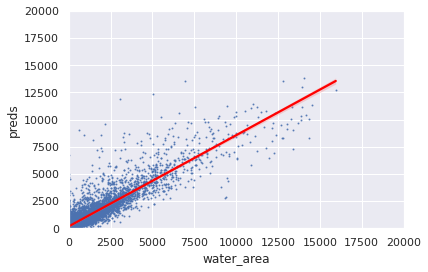

In [71]:
# plot up validation data preds vs measured values
ax = sns.regplot(x="water_area", y="preds", data=val_y,
                 scatter_kws={'s':1},
                 line_kws={"color": "red"})

ax.set(ylim=(0, max_value))
ax.set(xlim=(0, max_value))

In [72]:
# use numpy to calc the line of best fit equation
np.polyfit(val_y['water_area'], val_y['preds'], 1)

array([  0.83855382, 173.61397474])

In [73]:
# calc the model error and abs error 
val_y['error'] = val_y['preds']-val_data['water_area']
val_y['abs_error'] = abs(val_y['error'])
val_y.head()

,water_area,preds,error,abs_error,dist_from_mean
0,400.256079,267.783081,-132.472998,132.472998,615.010308
1,5781.220903,4708.409180,-1072.811723,1072.811723,4765.954516
2,581.212166,619.694885,38.482719,38.482719,434.054221
3,317.463008,209.639618,-107.823390,107.823390,697.803379
4,508.559500,1090.993896,582.434397,582.434397,506.706887


In [74]:
# calc the mean abs model error
model_mean_error = val_y['abs_error'].mean()
model_mean_error

337.9148169945021

In [75]:
# we can now compare the model to if we had just predicted the mean values for each row
# calc the overall mean from the measured values
mean_value = val_y['water_area'].mean()
# calc the abs distance each row is from the mean
val_y['dist_from_mean'] = abs(val_y['water_area']-mean_value)
# calc the mean distance from the mean, this is comparable to the model_mean_error value above
mean_dist_from_mean = val_y['dist_from_mean'].mean()
mean_dist_from_mean

885.8515476619473

In [76]:
# we can now compare the model_mean_error with the mean_dist_from_mean
'The model is explaining '+f"{1-model_mean_error/mean_dist_from_mean:.0%}" +' of the variance'

'The model is explaining 62% of the variance'

In [77]:
# save model to disk
pickle.dump(xgb_reg, open(model_path, "wb"))

In [78]:
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_11-10-22.pkl'